In [2]:
import sys
sys.path.append('..')
from MPRA_predict.utils import *

In [ ]:
subprocess.run([
    'python', 'train_scripts/test_0504.py', 
    '-s', 'saved/0609_Gosai_MPRA_MyResTransformer_seq_3_cell_types/0609_025440/', 
    '-c', 'configs/config_0915_Gosai_MPRA_MyResTransformer_seq_3_cell_types_Zhang.yaml',
    '-o', 'Zhang_MPRA_pred.npy'],
    cwd='..'
)

In [8]:
# cell_types = ['K562', 'HepG2', 'HEK293T', 'Jurkat']
# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

In [3]:
MPRA_df = pd.read_csv("../data/Zhang_MPRA/Zhang_MPRA_Sei_feature_zscore.csv")

In [4]:
y_pred = np.load(f'../saved/0609_Gosai_MPRA_MyResTransformer_seq_3_cell_types/0609_025440/Zhang_MPRA_pred.npy')
cell_types = ['K562', 'HepG2', 'SK-N-SH']
cols = [f'{cell_type}_pred' for cell_type in cell_types]
MPRA_df[cols] = y_pred

In [5]:
cell_types = ['K562', 'HepG2', 'HEK293T', 'Jurkat']
cell_types_2 = ['K562', 'HepG2', 'SK-N-SH']

pearson_df = pd.DataFrame()
for cell_type in cell_types:
    for cell_type_2 in cell_types_2:
        df = MPRA_df
        x = df[f'{cell_type}']
        y = df[f'{cell_type_2}_pred']
        r, p = pearson(x, y)
        pearson_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r

print(pearson_df)

####### should be worst, but not

         K562_pred  HepG2_pred  SK-N-SH_pred
K562         0.822       0.733         0.759
HepG2        0.655       0.762         0.692
HEK293T      0.739       0.713         0.753
Jurkat       0.678       0.655         0.678


In [13]:
def plot_heatmap(df):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    data = np.array(df.values)
    col_labels = list(df.index)
    row_labels = list(df.columns)

    sns.set_theme(context='talk', style="white")
    fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.9, top=0.9)
    im = ax.imshow(data, cmap='coolwarm', vmin=0.2, vmax=1.0,)

    # 设置 divider 来控制 colorbar 的轴
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.2)  # size 为 colorbar 宽度，pad 为间距
    cbar = fig.colorbar(im, cax=cax)


    # 添加文本注释（跳过 NaN）
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            if not np.isnan(val):
                ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=16)

    # 设置坐标轴标签
    ax.set_xticks(np.arange(len(row_labels)))
    ax.set_yticks(np.arange(len(col_labels)))
    ax.set_xticklabels(row_labels, fontsize=16, rotation=45)
    ax.set_yticklabels(col_labels, fontsize=16)

    # 设置灰色网格线
    ax.set_xticks(np.arange(data.shape[1]+1)-0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-0.5, minor=True)
    ax.grid(which='minor', color='gray', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # 自动布局和保存
    # plt.tight_layout()
    # plt.savefig(f'figures/Gosai_MPRA_activity_vs_activity_{data_split}_heatmap.png', dpi=400)

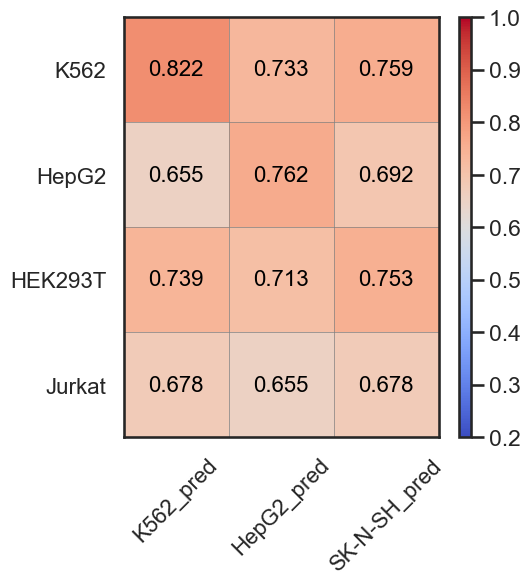

In [14]:
plot_heatmap(pearson_df)

In [17]:
data_split_dict = {}
# 计算每条序列在不同细胞类型中的最大值和最小值之差
MPRA_df['range'] = MPRA_df[cell_types].max(axis=1, skipna=True) - MPRA_df[cell_types].min(axis=1, skipna=True)
# 计算 range 的第95百分位
threshold = np.percentile(MPRA_df['range'].dropna(), 90)
# 前5%的高差值序列为 diff，其余为 const
data_split_dict['diff'] = MPRA_df['range'] > threshold
data_split_dict['const'] = ~data_split_dict['diff']

In [18]:
cell_types = ['K562', 'HepG2', 'HEK293T', 'Jurkat']
cell_types_2 = ['K562', 'HepG2', 'SK-N-SH']

pearson_df = pd.DataFrame()
for cell_type in cell_types:
    for cell_type_2 in cell_types_2:
        df = MPRA_df[data_split_dict['diff']]
        x = df[f'{cell_type}']
        y = df[f'{cell_type_2}_pred']
        r, p = pearson(x, y)
        pearson_df.loc[f'{cell_type}', f'{cell_type_2}_pred'] = r

print(pearson_df)

####### should be worst, but not

         K562_pred  HepG2_pred  SK-N-SH_pred
K562         0.687       0.350         0.594
HepG2        0.181       0.437         0.329
HEK293T      0.510       0.390         0.605
Jurkat       0.334       0.240         0.402


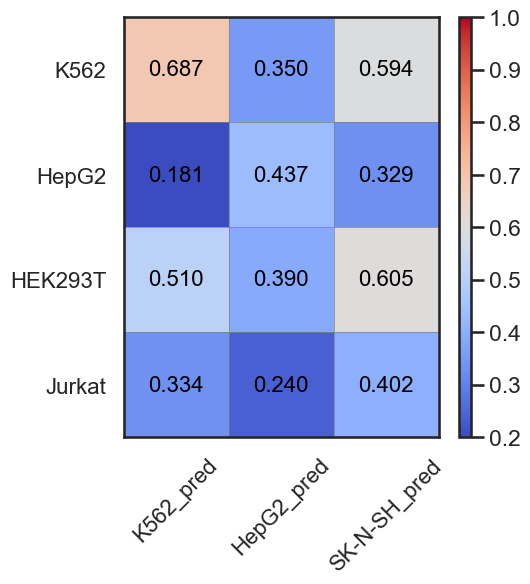

In [19]:
plot_heatmap(pearson_df)